# Gift Recommender Engine: Creating a Topic Classifier

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import spacy
import pickle

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, plot_confusion_matrix

In [6]:
data = pd.read_csv('datasets/train-test-data2.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.dropna(inplace=True)

In [7]:
data.head()

,category,clean-text
0,Electronics/Gadgets,new tech discord server unfortunately due extr...
1,Electronics/Gadgets,intel chief warn two year chip shortage
2,Electronics/Gadgets,new york state fight dismissal antitrust lawsu...
3,Electronics/Gadgets,microsoft profit skyrocket percent
4,Electronics/Gadgets,hide malware inside ai neural network


## Import Functions to Clean User Input

In [8]:
nlp = spacy.load('en_core_web_sm')

def spacy_lemmatize(text):
    if type(text) == list:
        doc = nlp(u"{}".format(' '.join(text)))
    else:
        doc = nlp(u"{}".format(text))
    lemmatized = list()
    for token in doc:
        lemmatized.append(token.lemma_)
    
    return lemmatized

In [151]:
punctuations = string.punctuation
stopwords = nltk.corpus.stopwords.words('english')

def preprocess(text):
    text = text.split() #split into list
    text = [re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE) for s in text] #remove any links
    text = [s.lower() for s in text] #convert every character into lowercase
    text = [re.sub(rf"[{string.punctuation}]", " ", s) for s in text] #remove punctuations
    text = [re.sub(r'[0-9]', ' ', s) for s in text] #remove all digits
    text = ' '.join(text)  #resplits
    text = [s for s in text.split() if len(s) >= 2] #removes words with one word length
    text = [s for s in text if s not in stopwords] #remove all stopwords
    text = ' '.join(spacy_lemmatize(text)) #lemmatize text using spacy and join into a string
    return text

## Modelling

### Splitting Training and Testing Data

In [10]:
X = data['clean-text']
y = data['category']

le = LabelEncoder()
y = le.fit_transform(y)

In [11]:
ref = dict(zip(data['category'].to_numpy(), y))
ref = {k:v for k,v in sorted(ref.items(), key=lambda item: item[1])}

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=8)

### Vectorizer Words

In [13]:
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

### Model 1: Multinomial Naive Bayes - Training and Evaluation

In [14]:
# Training a Multinomial Naive Bayes Model
nb = MultinomialNB()
nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

In [15]:
print('Naive Bayes Model Accuracy: {}%'.format(round(nb.score(X_test, y_test) * 100)))

Naive Bayes Model Accuracy: 89%


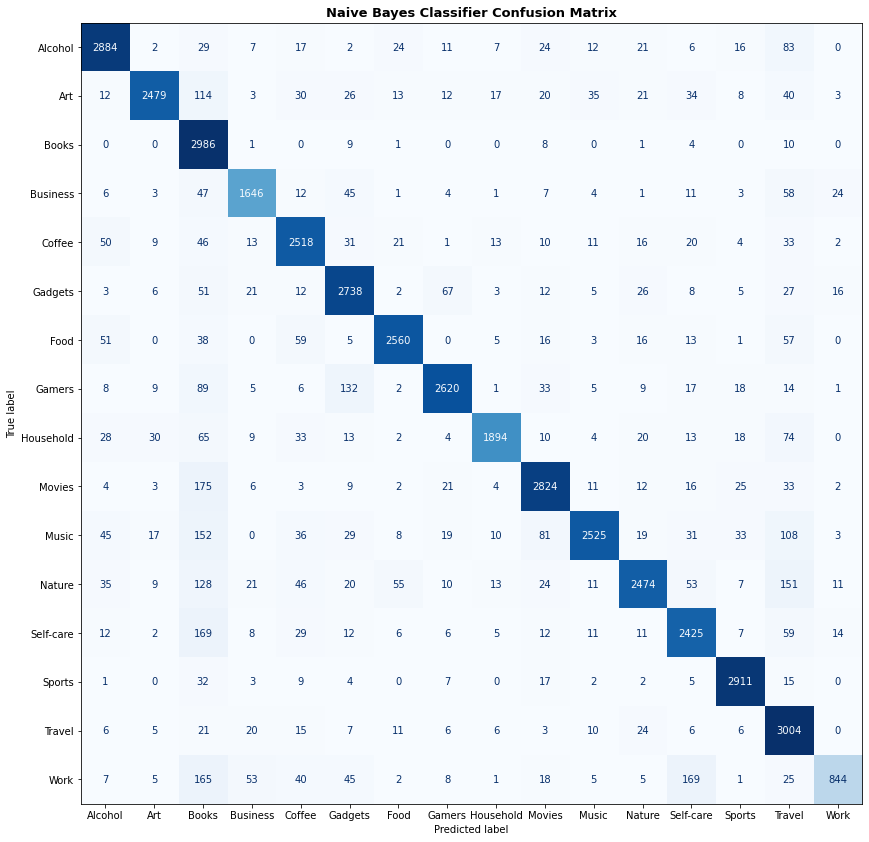

In [16]:
fig, ax = plt.subplots(figsize=(14,16))
labels = [k for k, v in ref.items()]
labels = np.char.replace(labels, 'Electronics/Gadgets', 'Gadgets')
plot_confusion_matrix(nb, X_test, y_test,cmap=plt.cm.Blues, ax=ax, colorbar=False, display_labels=labels)
ax.set_title('Naive Bayes Classifier Confusion Matrix', fontweight='bold', fontsize=13)
plt.show()

### Model 2: One vs. Rest Classifier Strategy, LinearSVC - Training and Evaluation

In [17]:
ovr_svc = OneVsRestClassifier(LinearSVC(random_state=0))
ovr_svc.fit(X_train, y_train)

OneVsRestClassifier(estimator=LinearSVC(random_state=0))

In [18]:
y_pred = ovr_svc.predict(X_test)
y_score = ovr_svc.fit(X_train, y_train).decision_function(X_test)

In [19]:
print('Support Vector Model Accuracy: {}%'.format(round(ovr_svc.score(X_test, y_test) * 100)))

Support Vector Model Accuracy: 98%


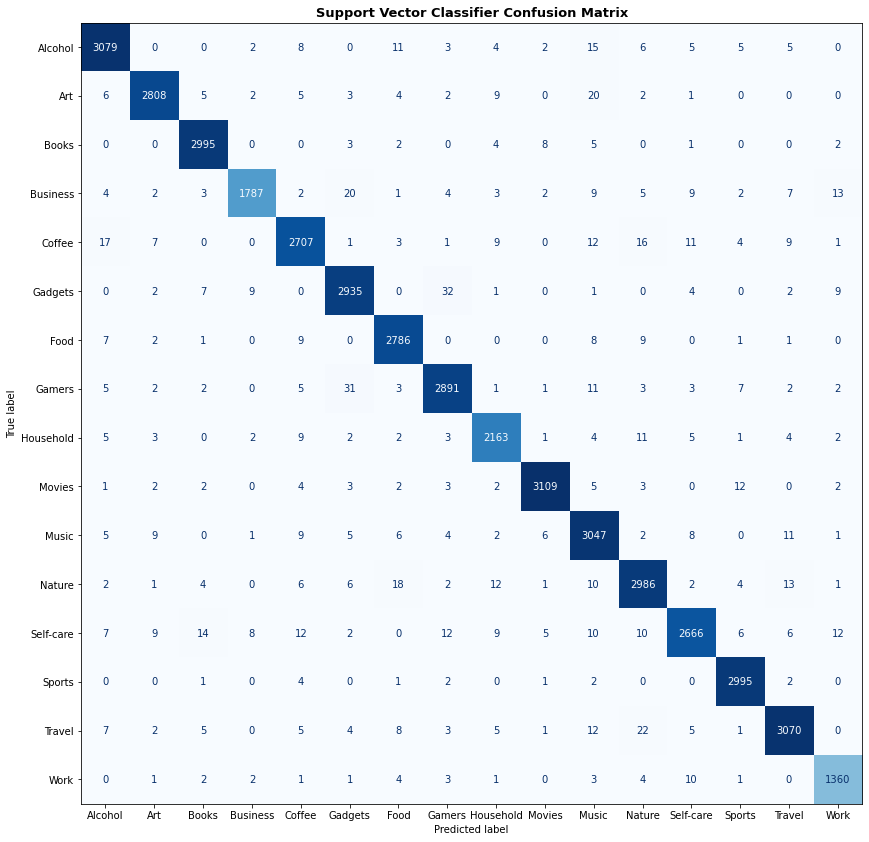

In [20]:
fig, ax = plt.subplots(figsize=(14,16))
labels = [k for k, v in ref.items()]
labels = np.char.replace(labels, 'Electronics/Gadgets', 'Gadgets')
plot_confusion_matrix(ovr_svc, X_test, y_test,cmap=plt.cm.Blues, ax=ax, colorbar=False, display_labels=labels)
ax.set_title('Support Vector Classifier Confusion Matrix', fontweight='bold', fontsize=13)
plt.show()

### Save Models to Pickle

In [21]:
#filename = open('models/nb_baseline1.pkl', 'wb')
#pickle.dump(nb, filename)

#filename = open('linear_svc_baseline.pkl', 'wb')
#pickle.dump(ovr_svc, filename)

### Sanity Check: Made Up Tweets!

In [22]:
key = {v:k for k, v in ref.items()}

In [144]:
nb_correct = ["My phone is broken, I really need a new one!", "I'm so tired at work, I really need to relax!", 
              "I'm so tired, I really need a vacation!", "I want to go on a holiday", "I love pandas", 
             "Went to the MET and saw Van Gogh portraits"]

svc_correct = ["Just went to the Grammys! Loved it"]

In [148]:
tweet = "Good days in my mind"
tweet = preprocess(tweet)
tweet = ' '.join(spacy_lemmatize(tweet))

In [149]:
tweet = tfidf.transform([tweet])

In [150]:
print('Support Vector Topic Prediction:', key[ovr_svc.predict(tweet)[0]])
print('Naive Bayes Topic Prediction:', key[nb.predict(tweet)[0]])

Support Vector Topic Prediction: Gamers
Naive Bayes Topic Prediction: Self-care


In [75]:
test = "Terrible at giving gifts? This web-app uses machine learning to predict a recipient's interests from tweets to recommend the perfect gift."

In [76]:
len(test)

139